# Finite Difference Testing
1. Testing that taking a trained energy model, `E=lr(X)`, can successfully predict forces: `[lr(X(r+dr)) - lr(X(r)))]/dr = -F(r)`
   * [SOAP](#soap-fd-forces)
   * [AniSOAP](#anisoap-fd-forces) 
2. Testing that the finite difference model `[X(r+dr) - X(r)]/dr` yields the same results as the analytical gradients.
   * [SOAP](#soap-fd)
   * [AniSOAP](#anisoap-fd) 

# SOAP Finite Difference Forces<a class="anchor" id="soap-fd-forces"></a>


In [1]:
from metatensor import TensorMap, TensorBlock
import metatensor
import numpy as np
from sklearn.linear_model import RidgeCV
from skmatter.preprocessing import StandardFlexibleScaler
def train_model(rep:TensorMap, e:np.ndarray, mode='soap'):
    """
    Train a linear model
    """
    if mode == 'soap':
        rep = rep.keys_to_samples("center_type")
        rep = rep.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])
        rep = metatensor.mean_over_samples(rep, ["atom", "center_type"])
    elif mode == 'anisoap':
        rep = rep.keys_to_samples("types_center")
        rep = metatensor.mean_over_samples(rep, ["center", "types_center"])
    else:
        raise ValueError("`mode` nees to be 'soap' or 'anisoap'")
    X_unnorm = rep.block().values.squeeze()
    X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
    X = X_scaler.transform(X_unnorm)

    y_scaler = StandardFlexibleScaler(column_wise=True).fit(e)
    y = y_scaler.transform(e) 
    lr = RidgeCV(alphas=np.logspace(-8,2,12), cv=5)
    lr.fit(X,y)
    print(lr.score(X,y))
    return lr, X,X_scaler, y,y_scaler

In [2]:
def rep_to_energy(rep:TensorMap, lr:RidgeCV, mode='soap'):
    """
    Predict Energies using pretrained regressor lr
    """
    if mode == 'soap':
        rep = rep.keys_to_samples("center_type")
        rep = rep.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])
        rep = metatensor.mean_over_samples(rep, ["atom", "center_type"])
    elif mode == 'anisoap':
        rep = rep.keys_to_samples("types_center")
        rep = metatensor.mean_over_samples(rep, ["center", "types_center"])
        X_unnorm = rep.block().values.squeeze()
    else:
        raise ValueError("`mode` nees to be 'soap' or 'anisoap'")
    X_unnorm = rep.block().values.squeeze()
    X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
    X = X_scaler.transform(X_unnorm)

    return lr.predict(X)


In [3]:
# Find the base soap descriptor, with no perturbations.
from ase.io import read
frames = read("./frames_1000.xyz", ":")
lmax=4
nmax=6

from featomic.calculators import SoapPowerSpectrum
HYPER_PARAMETERS = {
    "cutoff": {
        "radius": 5.0,
        "smoothing": {"type": "ShiftedCosine", "width": 0.5},
    },
    "density": {
        "type": "Gaussian",
        "width": 0.3,
    },
    "basis": {
        "type": "TensorProduct",
        "max_angular": lmax,
        "radial": {"type": "Gto", "max_radial": nmax},
    },
}

calculator = SoapPowerSpectrum(**HYPER_PARAMETERS)
base_rep = calculator.compute(frames, gradients=['positions'])

In [4]:
# Read Frames and associated energies and forces
from ase.io import read
frames = read("frames_1000.xyz", ":")
energies = []
forces = []
for frame in frames:
    energies.append(frame.get_total_energy())
    forces.append(frame.get_forces())
energies = np.array(energies).reshape(-1,1)
forces = np.asarray(forces)
print(energies.shape, forces.shape)

# Train base model and obtain scalers
lr, X,X_scaler, y,y_scaler = train_model(base_rep, energies, mode='soap')

(1000, 1) (1000, 12, 3)
0.9999919402983317


In [5]:
import signac 
from tqdm.auto import tqdm
project = signac.get_project()
delta = 0.01
rep_type = 'soap'
# for atom_i in range(12):    # One for each atom
#     for grad_dir in [0,1,2]:    # 'x' is 0, 'y' is 1, 'z' is 2
pred_forces_soap = np.zeros((1000, 12, 3))

for atom_i in tqdm(range(12)):    # One for each atom
    for grad_dir in [0,1,2]:    # 'x' is 0, 'y' is 1, 'z' is 2
        job = project.open_job({"rep_type":rep_type, "delta":delta, "atom_i":atom_i, "grad_dir":grad_dir})
        rep = metatensor.load(job.fn("rep.mts"))
        new_y = rep_to_energy(rep, lr,mode='soap')
        new_y = new_y.reshape(-1,1)
        new_e = y_scaler.inverse_transform(new_y)
        e = y_scaler.inverse_transform(y)    # same as original energies
        pred_forces_soap[:,atom_i,grad_dir] = (-(new_e - e)/delta).flatten()

/Users/alin62/miniconda3/envs/anisoap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 12/12 [03:38<00:00, 18.17s/it]


Text(0, 0.5, 'Predicted Forces SOAP Finite Diff')

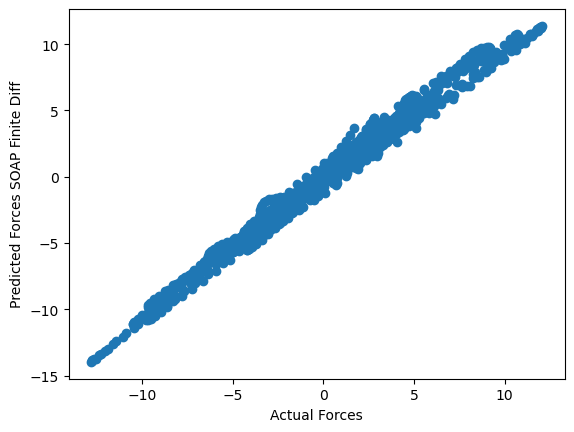

In [6]:
# Spot Check Parity Plots SOAP
atom_i=7
grad_dir=1
import matplotlib.pyplot as plt
plt.scatter(forces[:, atom_i, grad_dir], pred_forces_soap[:, atom_i, grad_dir])
plt.xlabel("Actual Forces")
plt.ylabel("Predicted Forces SOAP Finite Diff")

# AniSOAP Finite Difference Forces<a class="anchor" id="anisoap-fd-forces"></a>


In [7]:
# Now, do the exact same thing for AniSOAP. 
# Train the anisoap base rep
base_rep_anisoap = metatensor.load("base_rep_anisoap.mts")
lr, X,X_scaler, y,y_scaler = train_model(base_rep_anisoap, energies, mode='anisoap')

0.9995147064646669


In [8]:
import signac 
from tqdm.auto import tqdm
project = signac.get_project()
delta = 0.01
rep_type = 'anisoap'
# for atom_i in range(12):    # One for each atom
#     for grad_dir in [0,1,2]:    # 'x' is 0, 'y' is 1, 'z' is 2
pred_forces_anisoap = np.zeros((1000, 12, 3))

for atom_i in tqdm(range(12)):    # One for each atom
    for grad_dir in [0,1,2]:    # 'x' is 0, 'y' is 1, 'z' is 2
        job = project.open_job({"rep_type":rep_type, "delta":delta, "atom_i":atom_i, "grad_dir":grad_dir})
        rep = metatensor.load(job.fn("rep.mts"))
        new_y = rep_to_energy(rep, lr, mode=rep_type)
        new_y = new_y.reshape(-1,1)
        new_e = y_scaler.inverse_transform(new_y)
        e = y_scaler.inverse_transform(y)    # same as original energies
        pred_forces_anisoap[:,atom_i,grad_dir] = (-(new_e - e)/delta).flatten()

100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


Text(0, 0.5, 'Predicted Forces AniSOAP Finite Diff')

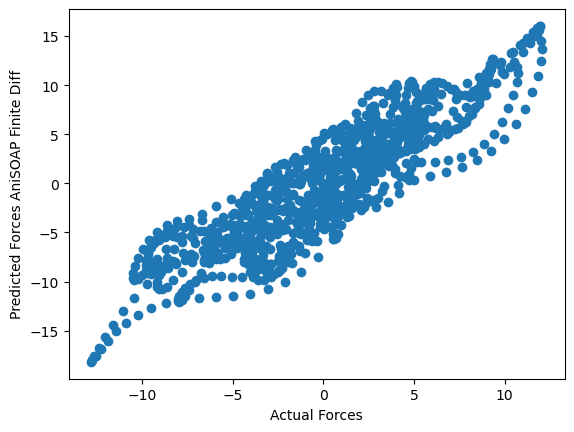

In [9]:
# Spot Check Parity Plots SOAP
atom_i=7
grad_dir=1
import matplotlib.pyplot as plt
plt.scatter(forces[:, atom_i, grad_dir], pred_forces_anisoap[:, atom_i, grad_dir])
plt.xlabel("Actual Forces")
plt.ylabel("Predicted Forces AniSOAP Finite Diff")

Finite Difference Parity Plots for AniSOAP look worse than SOAP's

# SOAP Finite Difference<a class="anchor" id="soap-fd"></a>
Extract the gradients from the SOAP base rep and compare with the finite-difference approximation

In [10]:
from metatensor import TensorMap, TensorBlock, Labels
from sklearn.linear_model import RidgeCV
from skmatter.preprocessing import StandardFlexibleScaler
import numpy as np
import signac

def filter_gradient_tensorblock(block:TensorBlock, atom_i:int, dim='sample'):
    # Return a new tensorblock with only atom_i, filtered by sample dimension
    if dim != 'sample':
        return ValueError("For now, dim must be 'sample'")
    mask = (block.samples.view("atom").values == atom_i).flatten()
    new_values = block.values[mask, :, :]
    new_samples = Labels(
        names=block.samples.names,
        values=block.samples.values[mask]
    )
    return TensorBlock(
        samples=new_samples,
        properties=block.properties,
        components=block.components,
        values=new_values
    )

def get_soap_model_atom_i(rep:TensorMap, atom_i:int, grad_dir:int, e:np.ndarray, f:np.ndarray, mode='soap'):
    if mode == 'soap':
        rep = rep.keys_to_samples("center_type")
        rep = rep.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])
        rep = metatensor.mean_over_samples(rep, ["atom", "center_type"])
    elif mode == 'anisoap':
        rep = rep.keys_to_samples("types_center")
        rep = metatensor.mean_over_samples(rep, ["center", "types_center"])
        X_unnorm = rep.block().values.squeeze()
        X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
        X = X_scaler.transform(X_unnorm)
        return _, X,X_scaler, _
    else: 
        raise ValueError("`mode` needs to be 'soap' or 'anisoap")
    X_unnorm = rep.block().values.squeeze()
    X_grad_unnorm = filter_gradient_tensorblock(rep.block().gradient("positions"), atom_i).values[:,grad_dir,:]
    X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
    X = X_scaler.transform(X_unnorm)
    X_grad_scaler = StandardFlexibleScaler(column_wise=False).fit(X_grad_unnorm)
    X_grad = X_grad_scaler.transform(X_grad_unnorm)
    # Normalize the forces and energies. Note that y_ngradx is the negative of dy/dx
    y_scaler = StandardFlexibleScaler(column_wise=True).fit(e)
    y = y_scaler.transform(e) 
    # Use atom_i to extract the particular atom
    fx = f[:,atom_i,0].reshape(-1,1)
    print(fx.shape)
    y_ngradx_scaler = StandardFlexibleScaler(column_wise=True).fit(fx)
    y_ngradx = y_ngradx_scaler.transform(fx)
    print(y_ngradx.shape)
    from sklearn.linear_model import RidgeCV
    lr = RidgeCV(alphas=np.logspace(-8,2,12), cv=5)
    lr.fit(X, y)
    print(lr.score(X,y))
    print(lr.score(-X_grad, y_ngradx))
    return lr, X,X_scaler, X_grad

(1000, 1)
(1000, 1)
0.9940783064799119
-121.80747210390977
(1000, 1)
(1000, 1)
0.9999919402983317
-133.2959161079288


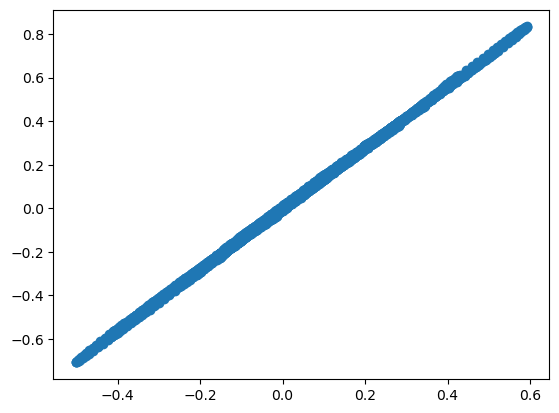

In [11]:
# Calculate SOAP finite differences: calculate the perturbed SOAP
import signac
import metatensor
import matplotlib.pyplot as plt
project = signac.get_project()
dir(project)
rep_type = 'soap'
delta=0.01
grad_dir = 0
atom_i = 0
job=project.open_job({"rep_type":rep_type, "delta":delta, "atom_i":atom_i, "grad_dir":grad_dir})
rep = metatensor.load(job.fn("rep.mts"))
_, new_X, new_X_scaler, _ = get_soap_model_atom_i(rep, atom_i, grad_dir, energies, forces)

# Calculate SOAP finite differences: calculate the original SOAP descriptor
base_rep = calculator.compute(frames, gradients=['positions'])
_, X, X_scaler, X_grad = get_soap_model_atom_i(base_rep, atom_i, grad_dir, energies, forces)

X_gradx_fd = (new_X - X) / delta
plt.scatter(X_grad.flatten(), X_gradx_fd.flatten())

We see that the finite difference code produces nearly identical gradients to the analytical gradients for SOAP.

# AniSOAP Finite Difference<a class="anchor" id="anisoap-fd"></a>
Extract the gradients from the AniSOAP base rep and compare with the finite-difference approximation

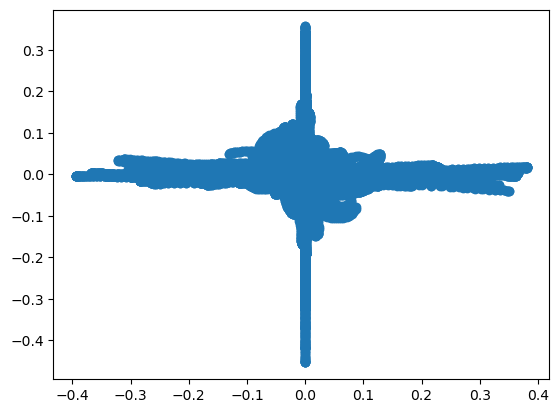

In [12]:
# Calculate AniSOAP finite differences: Extract the perturbed AniSOAP Data matrix
import signac
import metatensor
project = signac.get_project()
dir(project)
rep_type = 'anisoap'
delta=0.01
grad_dir = 0
atom_i = 0
job=project.open_job({"rep_type":rep_type, "delta":delta, "atom_i":atom_i, "grad_dir":grad_dir})
rep = metatensor.load(job.fn("rep.mts"))

rep = rep.keys_to_samples("types_center")
rep = metatensor.mean_over_samples(rep, ["center", "types_center"])
X_unnorm = rep.block().values.squeeze()
X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
new_X = X_scaler.transform(X_unnorm)

# Calculate AniSOAP finite differences: calculate the original AniSOAP descriptor
base_rep = metatensor.load("base_rep_anisoap.mts")
base_rep = base_rep.keys_to_samples("types_center")
base_rep = metatensor.mean_over_samples(base_rep, ["center", "types_center"])
X_unnorm = base_rep.block().values.squeeze()
X_scaler = StandardFlexibleScaler(column_wise=False).fit(X_unnorm)
X= X_scaler.transform(X_unnorm)

X_gradx_fd = (new_X - X) / delta

X_grad_unnorm = filter_gradient_tensorblock(base_rep.block().gradient("positions"), atom_i).values[:,grad_dir,:].squeeze()
X_grad_scaler = StandardFlexibleScaler(column_wise=False).fit(X_grad_unnorm)
X_grad = X_grad_scaler.transform(X_grad_unnorm)
plt.scatter(X_grad.flatten(), X_gradx_fd.flatten())

The parity plot above shows that there is a bug in the anisoap gradient code. Coincidentally, looks like one of the pca clusters we saw.